In [3]:
import pandas as pd
import numpy as np
import pdb 
from datetime import datetime, timedelta
from dis import dis
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

pd.options.mode.chained_assignment = None  # default='warn'

data = pd.read_csv("prepped_data.csv")

In [2]:
data_per_image = data.groupby(['origin']).mean()
data_per_image = data_per_image.sort_values(by=["score"])

# For malginant and benign images each
images = np.unique(data['origin'])

image_class = []
for i in images:
    tmp_label = data.loc[data['origin'] == i]['current_correct_answer'].iloc[0]
    image_class.append(tmp_label)
    
sort_by_image_id = data_per_image.sort_index()[:len(images)] #sort images by image name
sort_by_image_id['class'] = image_class

# retrieve melanoma and nevus images
melanoma = sort_by_image_id.loc[sort_by_image_id['class']=="['melanoma']"]
nevus = sort_by_image_id.loc[sort_by_image_id['class']=="['nevus']"]

#sort nevus descending and turn negative, melanoma ascending
melanoma.sort_values(by=["score"], inplace = True)
nevus.sort_values(by=["score"], ascending = False, inplace = True)
nevus  = nevus*-1
combined_images = nevus.append(melanoma)

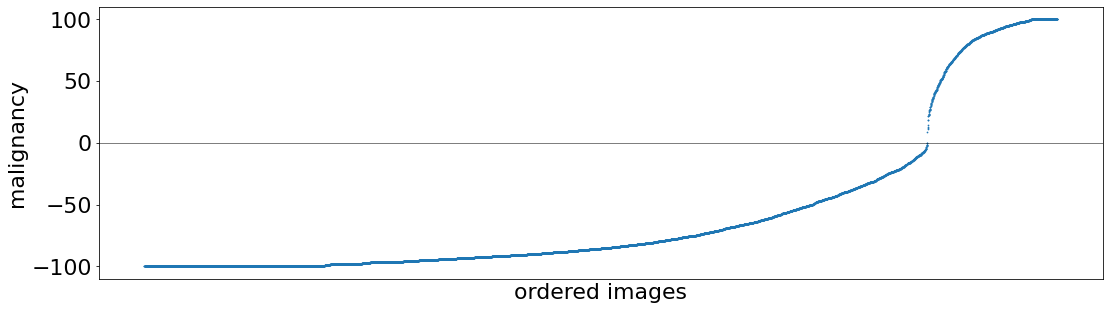

In [4]:
# Malignancy plot
x = combined_images.index
y = combined_images['score']
plt.figure(figsize=(18, 5))
plt.scatter(x,y,s=0.5)
plt.axhline(y=0,linewidth=0.5, color='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('malignancy')
plt.xlabel('ordered images')
plt.show()

In [ ]:
# number of malignant images: 1110, min times an image was shown: 95, max: 380:
data['origin'][data['current_correct_answer']== "['melanoma']"].value_counts() 

# number of benign images: 6688, min times an image was shown: 34, max: 106:
data['origin'][data['current_correct_answer']== "['nevus']"].value_counts() 

In [6]:
malignancy = combined_images['score']
data['malignancy'] = np.nan

for i,n in enumerate(malignancy.index):
    data['malignancy'][data['origin']==n] = malignancy.values[i]   

In [7]:
similarity = data['malignancy'].shift(periods = 1) - data['malignancy'] #previous - current malignancy 
data['similarity_to_previous'] = similarity
data['similarity_bins'] = pd.cut(x=similarity, bins=np.arange(-200,200,10))
data_per_bin = data.groupby(['similarity_bins']).mean()

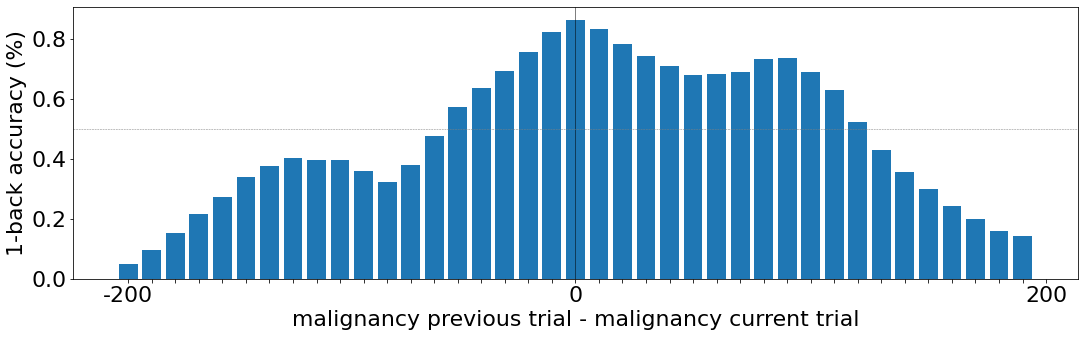

In [8]:
# PLOT 1: Similarity Barplot over all trials
y = data_per_bin['1back_accuracy']
x = data_per_bin.index
y_pos = np.arange(len(x))
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[19] = 0
x_labels[39] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('1-back accuracy (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=19,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--') #

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: above 0.5 SD is apparent

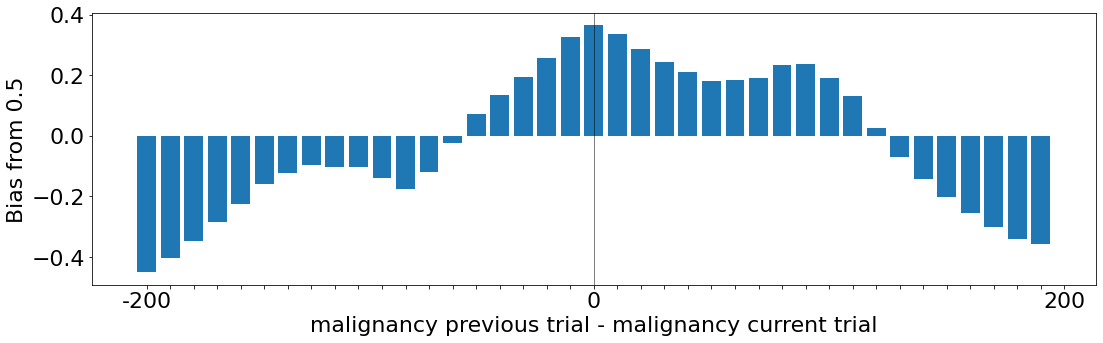

In [12]:
# PLOT 2: Similarity Barplot over all trials
y = data_per_bin['1back_accuracy']
y = y-0.5
x = data_per_bin.index
y_pos = np.arange(len(x))
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[19] = 0
x_labels[39] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Bias from 0.5')
plt.xlabel('malignancy previous trial - malignancy current trial')
#plt.title('Bias towards previous image for different levels of similarity')

plt.axvline(x=19,linewidth=0.5, color='black')

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: -0.5: Bias away from previous image, 0.5: Bias towards previous images 

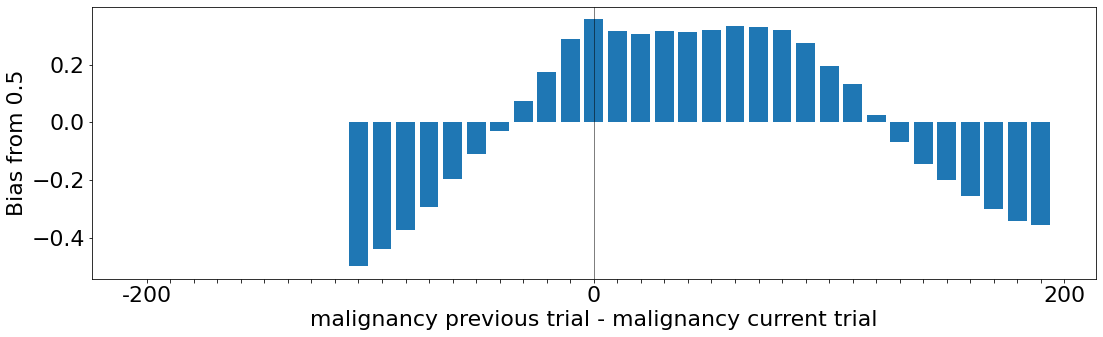

In [13]:
# PLOT 3: Similarity Barplot FOR NEVUS IN CURRENT TRIAL ONLY

nevus_only = data[data['current_correct_answer']== "['nevus']"]
data_per_bin_n = nevus_only.groupby(['similarity_bins']).mean()

y = data_per_bin_n['1back_accuracy']
y = y-0.5
y = y.fillna(0)
x = data_per_bin_n.index
y_pos = np.arange(len(x))
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[19] = 0
x_labels[39] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Bias from 0.5')
plt.xlabel('malignancy previous trial - malignancy current trial')
#plt.title('Bias towards previous image for different levels of similarity: Benign images in current trial only')

plt.axvline(x=19,linewidth=0.5, color='black')

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: -0.5: Bias away from previous image, 0.5: Bias towards previous images 

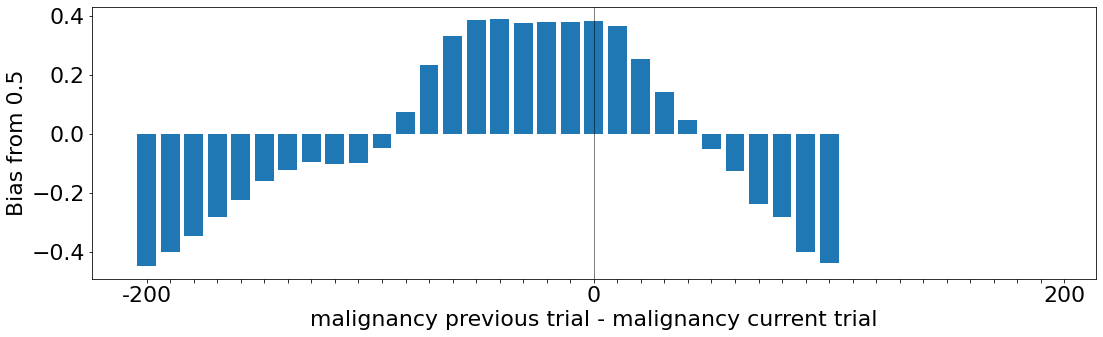

In [14]:
# PLOT 4: Similarity Barplot FOR MELANOMA IN CURRENT TRIAL ONLY

melanoma_only = data[data['current_correct_answer']== "['melanoma']"]
data_per_bin_m = melanoma_only.groupby(['similarity_bins']).mean()

y = data_per_bin_m['1back_accuracy']
y = y-0.5
y = y.fillna(0)
x = data_per_bin_m.index
y_pos = np.arange(len(x))
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[19] = 0
x_labels[39] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Bias from 0.5')
plt.xlabel('malignancy previous trial - malignancy current trial')
#plt.title('Bias towards previous image for different levels of similarity: Malignant images in current trial only')

plt.axvline(x=19,linewidth=0.5, color='black')

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: -0.5: Bias away from previous image, 0.5: Bias towards previous images 

In [ ]:
data.to_csv('prepped_data.csv')